<a href="https://colab.research.google.com/github/Cralsic123/Optuna-for-abalone-dataset/blob/main/Baseline_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.0 MB/s eta 0:00:00


In [18]:
!pip install colorama

In [20]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 954.7 kB/s eta 0:00:00


In [22]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.7 MB/s eta 0:00:00


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import scipy
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
from colorama import Style, Fore
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, mean_squared_log_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c playground-series-s4e4

  0% 0.00/2.41M [00:00<?, ?B/s]
100% 2.41M/2.41M [00:00<00:00, 127MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/playground-series-s4e4.zip', 'r') as zip_ref:
    zip_ref.extractall('./')



In [7]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [10]:
train.rename(columns={'Whole weight.1':'Whole_weight_1',
                      'Whole weight.2':'Whole_weight_2',
                      'Whole weight':'Whole_weight',
                      'Shell weight':'Shell_weight'},inplace=True)
test.rename(columns={'Whole weight.1':'Whole_weight_1',
                     'Whole weight.2':'Whole_weight_2',
                     'Whole weight':'Whole_weight',
                     'Shell weight':'Shell_weight'},inplace=True)

In [13]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
    .bar(subset=['mean'],color='green')\
    .bar(subset=['max'],color='red')\
    .bar(subset=['min'], color='pink')

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
id,int64,90615,90615,100.000000,0,0.000000,45307.000000,26158.441658,0.000000,22653.500000,45307.000000,67960.500000,90614.000000
Rings,int64,90615,28,0.030900,0,0.000000,9.696794,3.176221,1.000000,8.000000,9.000000,11.000000,29.000000
Length,float64,90615,157,0.173260,0,0.000000,0.517098,0.118217,0.075000,0.445000,0.545000,0.600000,0.815000
Diameter,float64,90615,126,0.139050,0,0.000000,0.401679,0.098026,0.055000,0.345000,0.425000,0.470000,0.650000
Height,float64,90615,90,0.099321,0,0.000000,0.135464,0.038008,0.000000,0.110000,0.140000,0.160000,1.130000
Whole_weight,float64,90615,3175,3.503835,0,0.000000,0.789035,0.457671,0.002000,0.419000,0.799500,1.067500,2.825500
Whole_weight_1,float64,90615,1799,1.985323,0,0.000000,0.340778,0.204428,0.001000,0.177500,0.330000,0.463000,1.488000
Whole_weight_2,float64,90615,979,1.080395,0,0.000000,0.169422,0.100909,0.000500,0.086500,0.166000,0.232500,0.760000
Shell_weight,float64,90615,1129,1.245931,0,0.000000,0.225898,0.130203,0.001500,0.120000,0.225000,0.305000,1.005000
Sex,object,90615,3,0.003311,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [24]:
num_cols = list(train._get_numeric_data())
cat_cols = list(train.drop(num_cols, axis = 1))
target='Rings'
num_cols.remove(target)

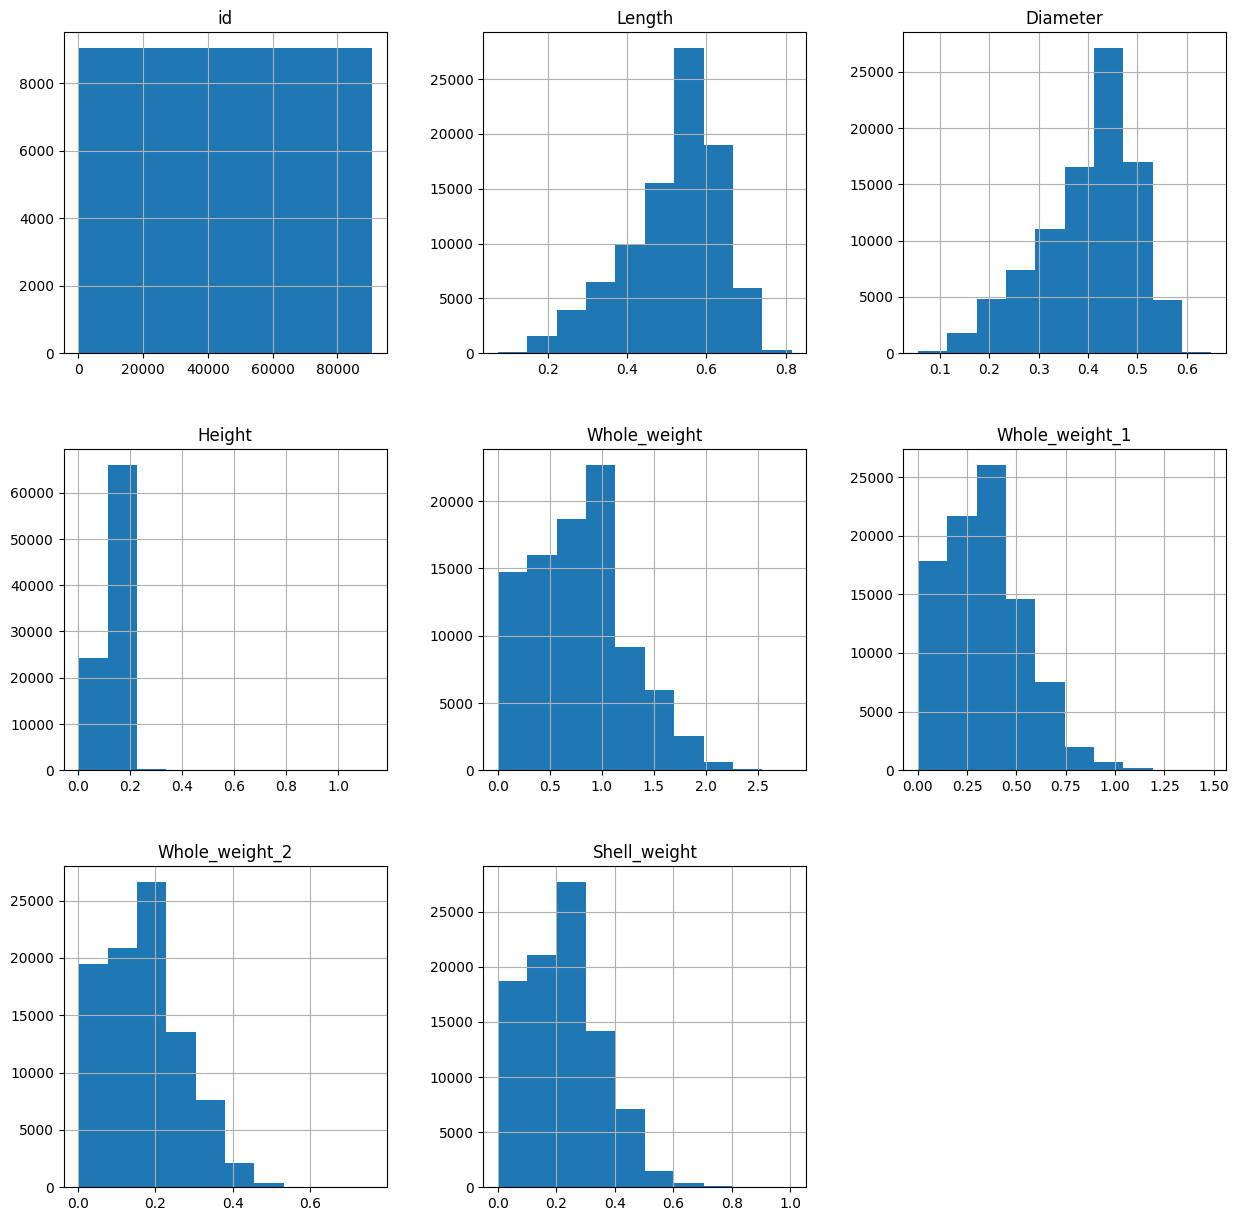

In [25]:
train[num_cols].hist(figsize=(15,15));

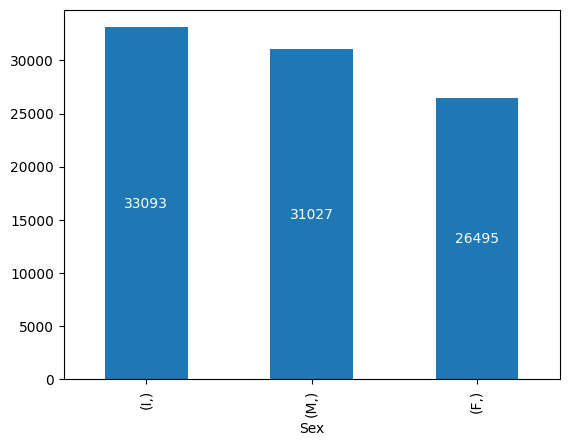

In [26]:
ax = train[cat_cols].value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0],label_type='center', color='white');